In [2]:
import numpy as np
import xarray as xr
import yaml
from pathlib import Path
from kalman_reconstruction.custom_plot import (
    set_custom_rcParams,
    adjust_lightness,
    plot_colors,
    symmetrize_axis,
    handler_map_alpha,
    symmetrize_axis,
    plot_state_with_probability,
)
# from reconstruct_climate_indices.idealized_ocean import sponge_ocean, oscillatory_ocean
from reconstruct_climate_indices.statistics import linear_regression_loglog, xarray_dataset_welch
from kalman_reconstruction.pipeline import from_standard_dataset, add_random_variable
from kalman_reconstruction import pipeline
from kalman_reconstruction.statistics import normalize, crosscorr
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
# from sklearn.linear_model import LinearRegression
from scipy import signal

In [3]:
from importlib import reload

reload(pipeline)

<module 'kalman_reconstruction.pipeline' from 'C:\\Users\\Niebaum\\Documents\\Repositories\\kalman-reconstruction-partially-observered-systems\\kalman_reconstruction\\pipeline.py'>

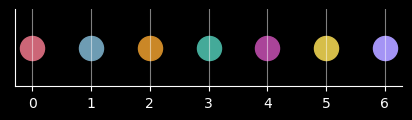

In [4]:
# ## LIGHT THEME
# plt.style.use("seaborn-v0_8-whitegrid")
# dark_color = [0.3, 0.3, 0.3]
# light_color = [0.8, 0.8, 0.8]
# lightness_0 = 0.75
# lightness_1 = 0.5
# cmap = "rocket"
# cmap_r = "rocket_r"

### DARK THEME
plt.style.use("dark_background")
dark_color = [0.7, 0.7, 0.7]
light_color = [0.2, 0.2, 0.2]
lightness_0 = 1.15
lightness_1 = 1.5
cmap = "rocket_r"
cmap_r = "rocket"


colors = set_custom_rcParams()
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["axes.grid"] = True

plot_colors(colors)

variables_color = dict()
variables_color["SAT"] = colors[0]
variables_color["SST"] = colors[2]
variables_color["DOT"] = colors[1]
variables_color["latent"] = colors[3]
variables_color["loglikelihood"] = (colors[-1],)

In [5]:
REPO_PATH = Path(".").resolve().parent
results_path = REPO_PATH / Path("results") / "Presentation" / "Kalman_Example_1000y"
results_path.mkdir(parents=True, exist_ok=True)
SAVE_FIGURES = True


def save_fig(fig, relative_path, **kwargs):
    store_path = results_path / relative_path
    store_path.parent.mkdir(parents=True, exist_ok=True)
    if SAVE_FIGURES:
        fig.savefig(store_path, **kwargs)
    else:
        pass

In [6]:
df = 0.115
tau0 = 10  # years
per0 = 24  # years
lambda0 = 2 / tau0  / (2 * np.pi) # years
omega0 = 2 * np.pi/per0  / (2 * np.pi)# years 

# NOTE: 
# The PSD units for the SAT are originally given in K^{2} d^{-1} y^{-1} but this is uglly
# So it is better to multuply the SAT by np.sqrt(1/365.25) to get it in K y^{-0.5} 
SAT_factor = 1 #np.sqrt(1/365.25) # factor by which the input to the fft function should be multiplied to get the units mentioned above
SAT_PSD_units = r"$K^2 y^{-2}$" 
SST_DOT_PSD_units = r"$K^2 y^{-1}$" 

print(rf"$\lambda_0$ = {lambda0}")
print(rf"$\omega_0$ = {per0}")


SAT_units = r"$K d^{-0.5}$" 
SST_DOT_units = r"$K$" 

# NOTE: 
# The PSD units for the SAT are originally given in K^{2} d^{-1} y^{-1} but this is uglly
# So it is better to multuply the SAT by np.sqrt(1/365.25) to get it in K y^{-0.5} 
SAT_factor = 1 #np.sqrt(1/365.25) # factor by which the input to the fft function should be multiplied to get the units mentioned above
SAT_PSD_units = r"$K^2 y^{-2}$" 
SST_DOT_PSD_units = r"$K^2 y^{-1}$" 

$\lambda_0$ = 0.03183098861837907
$\omega_0$ = 24


## Load Data

In [27]:
SubdataPath = "simplified_ocean_experiments"
sponge_run_name = "efficient-shrew-653"
oscillatory_run_name = "sincere-frog-475" 

dt = 30.4375

sponge_select_dict = dict(
    tau0=tau0 * 365.25,
    # time= slice(0,150*12*dt),
    # df=df,
)

oscillatory_select_dict = dict(
    per0=per0 * 365.25,
    tau0=tau0 * 365.25,
    # time= slice(0,150*12*dt),
    # seed=331381460666,
)

In [28]:
# Sponge ocean
run_name = sponge_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + "_kalman.nc")
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)

# Read YAML file
with open(SettingsPath, "r") as stream:
    sponge_settings = yaml.safe_load(stream)
select_dict = sponge_select_dict

sponge_data = experiments.sel(select_dict)
sponge_kalman = experiments_kalman.sel(select_dict)
sponge_kalman_states = experiments_kalman_states.sel(select_dict)
# sponge_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
#     select_dict
# )

In [ ]:
# Oscillatory ocean
run_name = oscillatory_run_name
RunPath = REPO_PATH / "data" / SubdataPath / run_name
InputPath = RunPath / (run_name + "_input.nc")
KalmanPath = RunPath / (run_name + "_kalman.nc")
SettingsPath = RunPath / (run_name + "_setup.yaml")

experiments = xr.open_dataset(InputPath)
experiments_kalman = xr.open_dataset(KalmanPath)
experiments_kalman_states = from_standard_dataset(experiments_kalman)

# Read YAML file
with open(SettingsPath, "r") as stream:
    oscillatory_settings = yaml.safe_load(stream)
select_dict = oscillatory_select_dict


oscillatory_data = experiments.sel(select_dict)
oscillatory_kalman = experiments_kalman.sel(select_dict)
oscillatory_kalman_states = experiments_kalman_states.sel(select_dict)
# oscillatory_kalman_states["loglikelihood"] = experiments_kalman["log_likelihod"].sel(
#     select_dict
# )

In [10]:
oscillatory_data.time_years[-1].values

array(999.91666667)

#### Load the random variablie setup

Create evolution of the random variabels from the settings file

In [34]:
# check if dicts are the same
assert oscillatory_settings["random_setup"] == sponge_settings["random_setup"]


rng_seed = oscillatory_settings["random_setup"]["seed"]
random_variance = oscillatory_settings["random_setup"]["random_variance"]
latent_names = oscillatory_settings["random_setup"]["name_random_variables"]
for var_name in  latent_names:
    
    rng = np.random.default_rng(seed=rng_seed)
    # add latent variabel to oscillatory ocean
    add_random_variable(
        ds=oscillatory_data,
        var_name=var_name,
        random_generator=rng,
        variance=random_variance,
    )
    # add latent variabel to sponge ocean
    rng = np.random.default_rng(seed=rng_seed)
    add_random_variable(
        ds=sponge_data,
        var_name=var_name,
        random_generator=rng,
        variance=random_variance,
    )

    rng_seed += 1

# oscillatory_data
# sponge_data

## Kalman_SEM

In [29]:
# check if dicts are the same
assert oscillatory_settings["kalman_setup"] == sponge_settings["kalman_setup"]

### load settings from one settings file kalman_setup
kalman_setup = oscillatory_settings["kalman_setup"].copy()
kalman_setup.pop("processing_function")
# nb_iter_SEM = kalman_setup["nb_iter_SEM"]
nb_iter_SEM = kalman_setup["nb_iter_SEM"]
np.testing.assert_allclose(oscillatory_kalman_states.kalman_iteration, sponge_kalman_states.kalman_iteration)


# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!! Use only 30 iterations !!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
nb_iter_SEM = 30

In [30]:
# sponge_kalman = pipeline.xarray_Kalman_SEM_full_output(
#     ds = sponge_data,
#     **kalman_setup
# )
# sponge_kalman_states = from_standard_dataset(sponge_kalman)
# # sponge_kalman_states["loglikelihood"] = sponge_kalman["log_likelihod"]

In [31]:
# oscillatory_kalman = pipeline.xarray_Kalman_SEM_full_output(
#     ds = oscillatory_data,
#     **kalman_setup
# )
# oscillatory_kalman_states = from_standard_dataset(oscillatory_kalman)
# # oscillatory_kalman_states["loglikelihood"] = oscillatory_kalman["log_likelihod"]

## All states animation

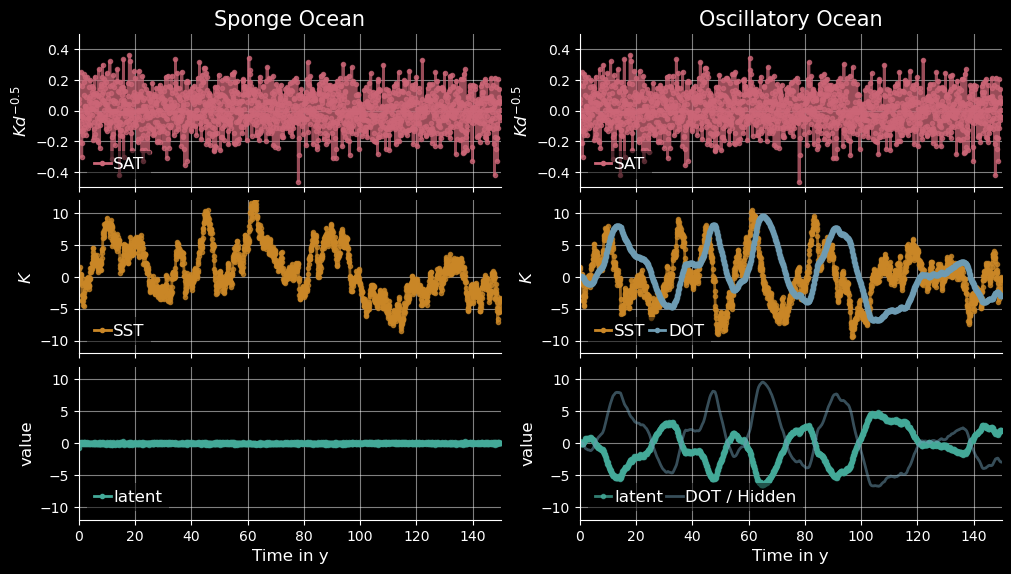

In [32]:
fig, axs = plt.subplots(nrows=3, ncols=2, layout="constrained", sharex=True, figsize = (10, 4.5*1.25))
kwargs = dict(
    linestyle="-",
    linewidth="2",
    marker=".",
    alpha = 0.75
)

time_slice = slice(0, 150*12)

axs_spunge = axs[:, 0]
axs_oscill = axs[:, 1]
axs_spunge[0].set_title("Sponge Ocean")
axs_oscill[0].set_title("Oscillatory Ocean")

# -------------------
# Plot SPONGE OCEAN
# -------------------

# Plot SAT
var = "SAT"
axs_spunge[0].plot(
    sponge_data["time_years"].isel(time = time_slice),
    sponge_data[var].isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)

# Plot SST
var = "SST"
line_SST_sponge, = axs_spunge[1].plot(
    sponge_data["time_years"].isel(time = time_slice),
    sponge_data[var].isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)


# -------------------
# Plot Oscillatory OCEAN
# -------------------
var = "SAT"
axs_oscill[0].plot(
    oscillatory_data["time_years"].isel(time = time_slice),
    oscillatory_data[var].isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)

var = "SST"
line_SST_oscillatory, = axs_oscill[1].plot(
    oscillatory_data["time_years"].isel(time = time_slice),
    oscillatory_data[var].isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)

var = "DOT"
line_DOT_oscillatory, = axs_oscill[1].plot(
    oscillatory_data["time_years"].isel(time = time_slice),
    oscillatory_data[var].isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)



# -------------------
# PLOT RECONSTRUCTION
# -------------------
# Sponge
var = "latent"
line_latent_sponge, = axs_spunge[2].plot(
    sponge_kalman_states["time_years"].isel(time = time_slice),
    sponge_kalman_states[var].isel(kalman_iteration = -1).isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)
# symmetrize_axis(axes=axs_spunge[2], axis="y")
# Oscillatory
var = "latent"
line_latent_oscillatory, = axs_oscill[2].plot(
    oscillatory_kalman_states["time_years"].isel(time = time_slice),
    oscillatory_kalman_states[var].isel(kalman_iteration = -1).isel(time = time_slice),
    label=var,
    color=variables_color[var],
    **kwargs,
)
var = "DOT"
axs_oscill[2].plot(
    oscillatory_data["time_years"].isel(time = time_slice),
    oscillatory_data[var].isel(time = time_slice),
    label=f"{var} / Hidden",
    color=variables_color[var],
    **dict(
        linestyle="-",
        linewidth="2",
        # marker=".",
        alpha = 0.5
    )
)


# Label and lims for SAT 
axs_spunge[0].set_ylabel(f"{SAT_units}")
axs_oscill[0].set_ylabel(f"{SAT_units}")
axs_oscill[0].set_ylim([-0.5, 0.5])
axs_spunge[0].set_ylim([-0.5, 0.5])

# Label and lims for SST and DOT
axs_spunge[1].set_ylabel(f"{SST_DOT_units}")
axs_oscill[1].set_ylabel(f"{SST_DOT_units}")
axs_oscill[1].set_ylim([-12, 12])
axs_spunge[1].set_ylim([-12, 12])

# Label and lims for latent and DOT
axs_spunge[2].set_ylabel(f"value")
axs_oscill[2].set_ylabel(f"value")
axs_oscill[2].set_ylim([-12, 12])
axs_spunge[2].set_ylim([-12, 12])

# set xlabel
axs_oscill[2].set_xlabel("Time in y")
axs_spunge[2].set_xlabel("Time in y")

for ax in axs.flatten() :
    ax.set_xlim([0, 150])
    ax.legend(
        ncols=2, 
        loc = "lower left",
        handlelength = 1,
        handletextpad=0.15,
        columnspacing=0.2,
        handler_map = handler_map_alpha()
        )
    
axs_oscill[2].legend(
    ncols=2, 
    loc = "lower left",
    handlelength = 1,
    handletextpad=0.15,
    columnspacing=0.2,
    # handler_map = handler_map_alpha()
    )
# save_fig(fig=fig, relative_path=f"Time_evolution_all_states_{years}y.pdf")

def init_lines(
        ):
    var = "latent"
    line_latent_sponge.set_ydata(
        sponge_kalman_states[var].isel(kalman_iteration = 0).isel(time = time_slice),
    )
    line_latent_oscillatory.set_ydata(
        oscillatory_kalman_states[var].isel(kalman_iteration = 0).isel(time = time_slice),
    )
    var = "SST"
    line_SST_sponge.set_ydata(
        sponge_kalman_states[var].isel(kalman_iteration = 0).isel(time = time_slice),
    )
    line_SST_oscillatory.set_ydata(
        oscillatory_kalman_states[var].isel(kalman_iteration = 0).isel(time = time_slice),
    )
    return line_latent_sponge, line_latent_oscillatory, line_SST_sponge, line_SST_oscillatory

def update_lines(
        idx, 
        ):
    var = "latent"
    line_latent_sponge.set_ydata(
        sponge_kalman_states[var].isel(kalman_iteration = idx).isel(time = time_slice),
    )
    line_latent_oscillatory.set_ydata(
        oscillatory_kalman_states[var].isel(kalman_iteration = idx).isel(time = time_slice),
    )
    var = "SST"
    line_SST_sponge.set_ydata(
        sponge_kalman_states[var].isel(kalman_iteration = idx).isel(time = time_slice),
    )
    line_SST_oscillatory.set_ydata(
        oscillatory_kalman_states[var].isel(kalman_iteration = idx).isel(time = time_slice),
    )
    return line_latent_sponge, line_latent_oscillatory, line_SST_sponge, line_SST_oscillatory

latent_ani = animation.FuncAnimation(
    fig, 
    update_lines,
    init_func=init_lines,
    save_count=nb_iter_SEM,
    interval = 200, 
    blit = True,
    )
# from IPython.display import HTML
# HTML(ani.to_html5_video())
# ani
# To save the animation using Pillow as a gif
writer = animation.FFMpegWriter(
    fps=1.5,
    metadata=dict(artist='Me'),
    bitrate=-1,
)
latent_ani.save(results_path / f'Kalman_SEM_all_states_tau0{tau0}_per0{per0}.mp4', writer=writer, dpi = 256)


## Evolution animation

### Animate the evolution of the latent variable

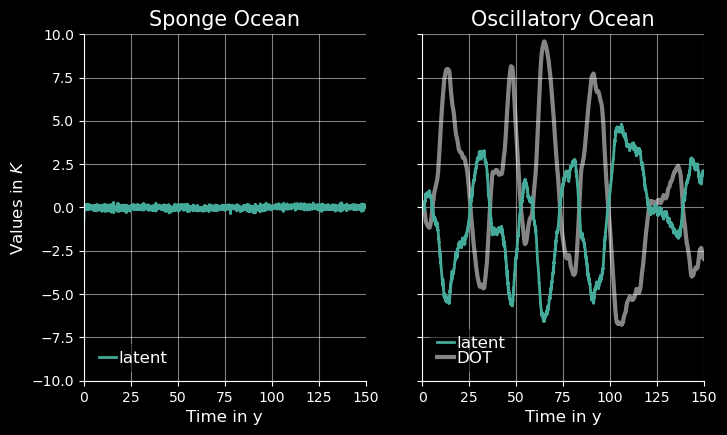

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey = True)
kwargs = dict(
    linestyle="-",
    linewidth="2",
    alpha = 1,
    color = variables_color["latent"]
)

time_slice = slice(0, 150*12)

line_sponge, = axs[0].plot(
    sponge_kalman_states.time_years.isel(time = time_slice),
    sponge_data.latent.isel(time = time_slice),
    label = "latent",
    **kwargs
    )

line_oscillatory, = axs[1].plot(
    oscillatory_kalman_states.time_years.isel(time = time_slice),
    oscillatory_data.latent.isel(time = time_slice),
    label = "latent",
    **kwargs
    )

axs[1].plot(
    oscillatory_data.time_years.isel(time = time_slice),
    oscillatory_data.DOT.isel(time = time_slice),
    linewidth = 3,
    linestyle = "-",
    label = "DOT",
    color = dark_color,
    alpha = 0.75,
    zorder = 0,
    )

# set limits 
for ax in axs : 
    ax.legend( 
        loc = "lower left",
        handlelength = 1,
        labelspacing=0.01,
        handletextpad=0.15,
        columnspacing=0.2,)
    # xlabel
    ax.set_xlabel(f"Time in y")
    ax.set_xlim(xmin = time_slice.start/12, xmax = time_slice.stop/12)
    # ylabel 
    ax.set_ylim(ymin = -10, ymax = 10)

axs[0].set_title("Sponge Ocean")
axs[0].set_ylabel(f"Values in {SST_DOT_units}")
axs[1].set_title("Oscillatory Ocean")

save_fig(fig, "Kalman_SEM_evolution.png", dpi = 256)

def init_lines(
        ):
    line_sponge.set_ydata(sponge_data.latent.isel(time = time_slice))
    line_oscillatory.set_ydata(oscillatory_data.latent.isel(time = time_slice))
    return line_sponge, line_oscillatory

def update_lines(
        idx, 
        ):
    if idx == 0:
        line_sponge.set_ydata(sponge_data.latent.isel(time = time_slice))
        line_oscillatory.set_ydata(oscillatory_data.latent.isel(time = time_slice))
    else :  
        idx -= 1
        line_sponge.set_ydata(sponge_kalman_states.latent.isel(time = time_slice).isel(kalman_iteration = idx))
        line_oscillatory.set_ydata(oscillatory_kalman_states.latent.isel(time = time_slice).isel(kalman_iteration = idx))
    return line_sponge, line_oscillatory

latent_ani = animation.FuncAnimation(
    fig, 
    update_lines,
    init_func=init_lines,
    save_count=nb_iter_SEM+1,
    interval = 200, 
    blit = True,
    )
# from IPython.display import HTML
# HTML(ani.to_html5_video())
# ani
# To save the animation using Pillow as a gif
writer = animation.FFMpegWriter(
    fps=1.5,
    metadata=dict(artist='Me'),
    bitrate=-1,
)
latent_ani.save(results_path / f'Kalman_SEM_evolution_tau0{tau0}_per0{per0}.mp4', writer=writer, dpi = 256)


### General hidden component

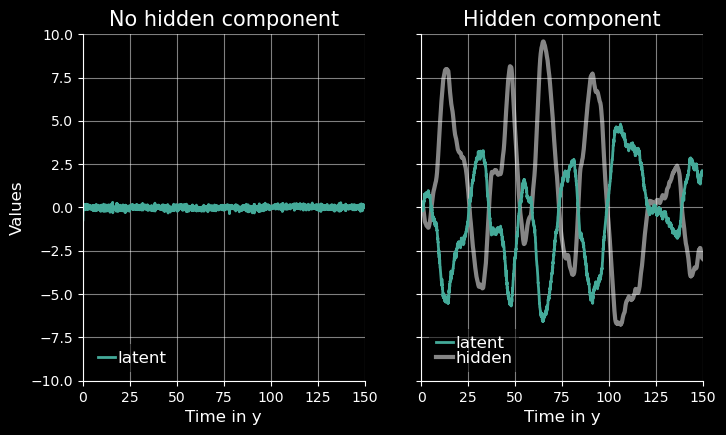

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey = True)
kwargs = dict(
    linestyle="-",
    linewidth="2",
    alpha = 1,
    color = variables_color["latent"]
)

time_slice = slice(0, 150*12)

line_sponge, = axs[0].plot(
    sponge_kalman_states.time_years.isel(time = time_slice),
    sponge_data.latent.isel(time = time_slice),
    label = "latent",
    **kwargs
    )

line_oscillatory, = axs[1].plot(
    oscillatory_kalman_states.time_years.isel(time = time_slice),
    oscillatory_data.latent.isel(time = time_slice),
    label = "latent",
    **kwargs
    )

axs[1].plot(
    oscillatory_data.time_years.isel(time = time_slice),
    oscillatory_data.DOT.isel(time = time_slice),
    linewidth = 3,
    linestyle = "-",
    label = "hidden",
    color = dark_color,
    alpha = 0.75,
    zorder = 0,
    )

# set limits 
for ax in axs : 
    ax.legend( 
        loc = "lower left",
        handlelength = 1,
        labelspacing=0.01,
        handletextpad=0.15,
        columnspacing=0.2,)
    # xlabel
    ax.set_xlabel(f"Time in y")
    ax.set_xlim(xmin = time_slice.start/12, xmax = time_slice.stop/12)
    # ylabel 
    ax.set_ylim(ymin = -10, ymax = 10)

axs[0].set_title("No hidden component")
axs[0].set_ylabel(f"Values")
axs[1].set_title("Hidden component")

def init_lines(
        ):
    line_sponge.set_ydata(sponge_data.latent.isel(time = time_slice))
    line_oscillatory.set_ydata(oscillatory_data.latent.isel(time = time_slice))
    return line_sponge, line_oscillatory

def update_lines(
        idx, 
        ):
    # if idx == 0:
    #     line_sponge.set_ydata(sponge_data.latent.isel(time = time_slice))
    #     line_oscillatory.set_ydata(oscillatory_data.latent.isel(time = time_slice))
    # else :  
        # idx -= 1
    line_sponge.set_ydata(sponge_kalman_states.latent.isel(time = time_slice).isel(kalman_iteration = idx))
    line_oscillatory.set_ydata(oscillatory_kalman_states.latent.isel(time = time_slice).isel(kalman_iteration = idx))
    return line_sponge, line_oscillatory

update_lines(0)
save_fig(fig, "Genral_hidden_init.svg", dpi = 256)
update_lines(nb_iter_SEM-1)
save_fig(fig, "Genral_hidden_final.svg", dpi = 256)


# latent_ani = animation.FuncAnimation(
#     fig, 
#     update_lines,
#     init_func=init_lines,
#     save_count=nb_iter_SEM,
#     interval = 200, 
#     blit = True,
#     )
# # from IPython.display import HTML
# # HTML(ani.to_html5_video())
# # ani
# # To save the animation using Pillow as a gif
# writer = animation.FFMpegWriter(
#     fps=1.5,
#     metadata=dict(artist='Me'),
#     bitrate=-1,
# )
# latent_ani.save(results_path / f'Genral_hidden.mp4', writer=writer, dpi = 256)


### M evolution

In [37]:
# cmap_RdBu = plt.get_cmap('RdBu_r').copy()
# # cmap_RdBu.set_extremes(under='b', over='r')

# # PLOT
# grid_kws = {'width_ratios': (0.49, 0.49, 0.02), 'wspace': 0.2}
# fig, (ax0, ax1, cbar_ax) = plt.subplots(1, 3, gridspec_kw = grid_kws, figsize = (8.5, 4))
# axs = np.array([ax0, ax1])

# heatmap_kwargs = dict(
#     xticklabels=sponge_kalman.state_name.values,
#     yticklabels=sponge_kalman.state_name_copy.values,
#     square=True,
#     annot=True,
#     fmt=".2f",
#     vmin = -1,
#     vmax = 1,
#     cmap = cmap_RdBu,
#     cbar_ax = cbar_ax,
#     cbar_kws = dict(label = r"Values of coefficients",extend = "both"),
# )


# sns.heatmap(
#     sponge_kalman.M.isel(kalman_iteration = 0), 
#     ax=axs[0], 
#     **heatmap_kwargs
# )
# axs[0].set_title("Sponge Ocean")
# # Plot standard deviation
# sns.heatmap(
#     oscillatory_kalman.M.isel(kalman_iteration = 0),
#     ax=axs[1],
#     **heatmap_kwargs,
# )
# axs[1].set_title("Oscilllatory Ocean")

# for ax in axs:
#     ax.set_xlabel(r"state")
# axs[0].set_ylabel(r"state")

# title = f"Coefficients of M"
# fig.suptitle(f"{title}")
# save_name = f"{title}" 

# def update_heatmap(
#         idx, 
#         ):    
#     # Plot mean 
#     axs[0].cla()
#     sns.heatmap(
#         sponge_kalman.M.isel(kalman_iteration = idx), 
#         ax=axs[0], 
#         **heatmap_kwargs
#     )
#     axs[1].cla()
#     # Plot standard deviation
#     sns.heatmap(
#         oscillatory_kalman.M.isel(kalman_iteration = idx),
#         ax=axs[1],
#         **heatmap_kwargs,
#     )

# ani_HM = animation.FuncAnimation(
#     fig, 
#     update_heatmap,
#     save_count=nb_iter_SEM,
#     blit = False,
#     )
# # from IPython.display import HTML
# # HTML(ani_HM.to_html5_video())

# writer = animation.FFMpegWriter(
#     fps=1.5,
#     metadata=dict(artist='Me'),
#     bitrate=-1,
# )
# ani_HM.save(results_path / f'M_Heatmap_tau0{tau0}_per0{per0}.mp4', writer=writer, dpi = 256)

### Get the length, timestep and so on

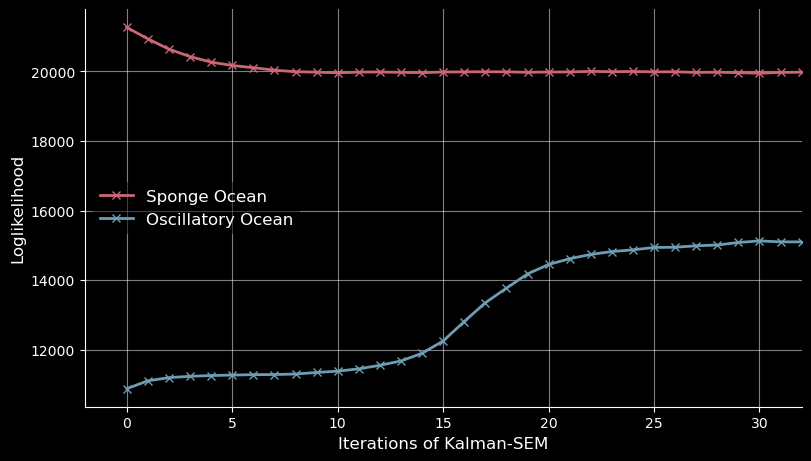

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, layout="constrained")

ax.plot(
    sponge_kalman["kalman_iteration"],
    sponge_kalman["log_likelihod"],
    label="Sponge Ocean",
    linewidth = 2,
    marker = "x"
)
ax.plot(
    oscillatory_kalman["kalman_iteration"],
    oscillatory_kalman["log_likelihod"],
    label="Oscillatory Ocean",
    linewidth = 2,
    marker = "x"
)
ax.set_xlabel("Iterations of Kalman-SEM")
ax.set_ylabel("Loglikelihood")
ax.legend(loc="center left")
ax.set_xlim(xmin = -2, xmax = 32)
# ax.set_title("Loglikelihood against iteartions of Kalman-SEM")

fig_name = f"Loglikelihood_tau0{tau0}_per0{per0}"
save_fig(fig=fig, relative_path=fig_name + ".pdf")
save_fig(fig=fig, relative_path=fig_name + ".png")

## Power Spectral Density

In [39]:
def get_dt(l):
    idx = 0
    for current_dataset in l:
        if idx == 0:
            dt = current_dataset.time[1] - current_dataset.time[0]
        else:
            assert dt == current_dataset.time[1] - current_dataset.time[0]
    return dt


def get_T(l):
    idx = 0
    for current_dataset in l:
        if idx == 0:
            T = current_dataset.time[-1] - current_dataset.time[0]
        else:
            assert T == current_dataset.time[-1] - current_dataset.time[0]
    return T / 365.25


dt = get_dt(
    [oscillatory_data, oscillatory_kalman_states, sponge_data, sponge_kalman_states]
).values
print(dt)
years = np.round(
    get_T(
        [oscillatory_data, oscillatory_kalman_states, sponge_data, sponge_kalman_states]
    ).values,
    decimals=2,
)
print(years)
# years = 1000
time_steps = years * 365.25 / dt
fs = 365.25 / dt  # 1/years
print(fs)
welch_window_width = 100  # years
nperseg = int(welch_window_width * fs)

30.4375
999.92
12.0


In [40]:
# Compute PSD with frequency in year**{-1}
# Set up welch_kwargs to use NO welch method.
welch_kwargs = dict(
    fs = fs,                    # period is 1/12 y -> fs = 12 y^{-1} 
    nperseg = nperseg,   # length in timesteps
    scaling = "density",
    window = "hann"
)

psd_sponge = xarray_dataset_welch(sponge_data, dim="time", welch_kwargs=welch_kwargs)
psd_oscillatory = xarray_dataset_welch(
    oscillatory_data, dim="time", welch_kwargs=welch_kwargs
)

psd_sponge_kalman = xarray_dataset_welch(
    sponge_kalman_states, dim="time", welch_kwargs=welch_kwargs
)
psd_oscillatory_kalman = xarray_dataset_welch(
    oscillatory_kalman_states, dim="time", welch_kwargs=welch_kwargs
)


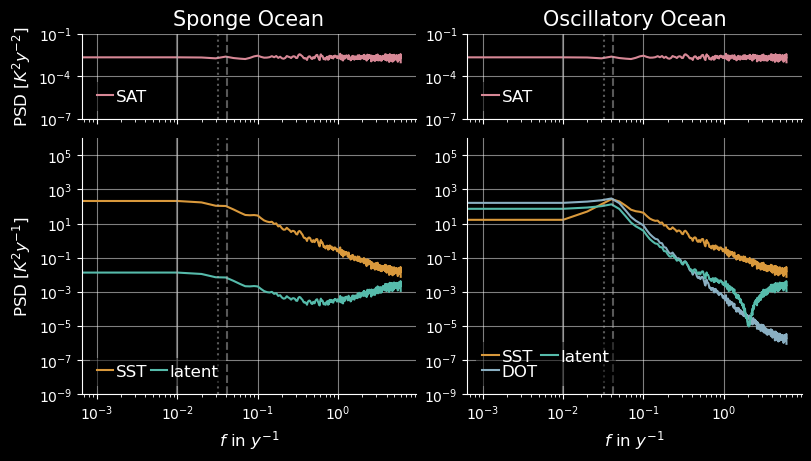

In [41]:
gs_kw = dict(height_ratios=[0.5, 1.5])
fig, axs = plt.subplots(
    nrows=2, ncols=2, layout="constrained", gridspec_kw=gs_kw, sharex=True, sharey=False
)
kwargs = dict(
    linestyle="-",
    linewidth="1",
    marker=".",
)

idx = 1  # x index to plot the text at

axs_spunge = axs[:, 0]
axs_oscill = axs[:, 1]
axs_spunge[0].set_title("Sponge Ocean")
axs_oscill[0].set_title("Oscillatory Ocean")


# ------------------
# plot Sponge
# ------------------
var = "SAT"
PSD_line_sponge_SAT, = axs_spunge[0].loglog(
        psd_sponge.frequency, 
        psd_sponge[var], 
        label=var, 
        color=adjust_lightness(variables_color[var], lightness_0),
        alpha = 1,
    )
var = "SST"
PSD_line_sponge_SST, = axs_spunge[1].loglog(
        psd_sponge.frequency, 
        psd_sponge[var], 
        label=var, 
        color=adjust_lightness(variables_color[var], lightness_0),
        alpha =1,
    )
var = "latent"
PSD_line_sponge_latent, = axs_spunge[1].loglog(
        psd_sponge_kalman.frequency, 
        psd_sponge_kalman[var].isel(kalman_iteration = 0), 
        label=var, 
        color=adjust_lightness(variables_color[var], lightness_0),
    )

# ------------------
# plot Oscillatory
# ------------------
var = "SAT"
PSD_line_osc_SAT, = axs_oscill[0].loglog(
        psd_oscillatory.frequency, 
        psd_oscillatory[var], 
        label=var, 
        color=adjust_lightness(variables_color[var], lightness_0),
        alpha = 1,
    )
var = "SST"
PSD_line_osc_SST, = axs_oscill[1].loglog(
        psd_oscillatory.frequency, 
        psd_oscillatory[var], 
        label=var, 
        color=adjust_lightness(variables_color[var], lightness_0),
        alpha = 1,
    )
var = "DOT"
PSD_line_osc_DOT, = axs_oscill[1].loglog(
        psd_oscillatory.frequency, 
        psd_oscillatory[var], 
        label=var,  
        color=adjust_lightness(variables_color[var], lightness_0),
        alpha = 1,
    )
var = "latent"
PSD_line_osc_latent, = axs_oscill[1].loglog(
        psd_oscillatory.frequency, 
        psd_oscillatory[var], 
        label=var, 
        color=adjust_lightness(variables_color[var], lightness_0),
    )
    
for ax in axs.flatten():
    # plot 1 / lambda9
    ax.axvline(lambda0, color=dark_color, linestyle=":", alpha = 0.5)
    # plot 1 / omega0
    ax.axvline(omega0, color=dark_color, linestyle="--", alpha = 0.5)
    # plot 1 / welch window width
    ax.axvline(1 / welch_window_width, color=dark_color, linestyle="-", alpha = 0.5)
    # plot legend
    ax.legend(
        ncols=2, 
        loc = "lower left",
        handlelength = 1,
        labelspacing=0.01,
        handletextpad=0.15,
        columnspacing=0.2,
        )

# fig.suptitle(
#     f"Power Density Spectrum of Latent variable, Observations and hidden Component"
# )
axs_spunge[0].set_ylabel(f"PSD [{SAT_PSD_units}]")
axs_spunge[1].set_ylabel(f"PSD [{SST_DOT_PSD_units}]")

axs_oscill[1].set_xlabel(r"$f$ in $y^{-1}$")
axs_spunge[1].set_xlabel(r"$f$ in $y^{-1}$")

for ax in [axs_spunge[1], axs_oscill[1]]:
    ax.set_ylim(ymin = 10**(-9))
    ax.set_ylim(ymax = 10**(6))
for ax in [axs_spunge[0], axs_oscill[0]]:
    ax.set_ylim(ymin = 10**(-7))
    ax.set_ylim(ymax = 10**(-1))
for ax in axs.flatten():
    ax.set_xlim(10**np.array([-3.18890756,  0.96705881]))
    
def init_lines(
        ):
    PSD_line_sponge_latent.set_ydata(psd_sponge["latent"])
    PSD_line_osc_latent.set_ydata(psd_oscillatory["latent"])
    return PSD_line_sponge_latent, PSD_line_osc_latent

def update_lines(
        idx, 
        ):
    if idx == 0:
        PSD_line_sponge_latent.set_ydata(psd_sponge["latent"])
        PSD_line_osc_latent.set_ydata(psd_oscillatory["latent"])
    else : 
        idx -= 1
        PSD_line_sponge_latent.set_ydata(psd_sponge_kalman["latent"].isel(kalman_iteration = idx))
        PSD_line_osc_latent.set_ydata(psd_oscillatory_kalman["latent"].isel(kalman_iteration = idx))
    return PSD_line_sponge_latent, PSD_line_osc_latent

update_lines(0)
save_fig(fig, relative_path="PSD_initial.svg")
update_lines(-1)
save_fig(fig, relative_path="PSD_final.svg")

ani_PSD = animation.FuncAnimation(
    fig, 
    update_lines,
    init_func=init_lines,
    save_count=nb_iter_SEM+1,
    interval = 200, 
    blit = True,
    )
# # from IPython.display import HTML
# # HTML(ani.to_html5_video())
# # ani
# # To save the animation using Pillow as a gif
writer = animation.FFMpegWriter(
    fps=1.5,
    metadata=dict(artist='Me'),
    bitrate=-1,
)
ani_PSD.save(results_path / f'PSD_evolution_tau0{tau0}_per0{per0}.mp4', writer=writer, dpi = 256)


In [42]:
# fig, axs = plt.subplots(
#     nrows=1, ncols=2, layout="constrained", sharex=True, sharey=True
# )
# kwargs = dict(
#     linestyle="-",
#     linewidth="1",
#     marker=".",
# )

# axs[0].set_title("Sponge Ocean")
# axs[1].set_title("Oscillatory Ocean")

# # ------------------
# # plot Sponge
# # ------------------
# var = "SAT"
# PSD_line_sponge_SAT, = axs[0].loglog(
#         psd_sponge.frequency, 
#         psd_sponge[var], 
#         label=var, 
#         color=adjust_lightness(variables_color[var], lightness_0),
#         alpha = 0.75,
#     )
# var = "SST"
# PSD_line_sponge_SST, = axs[0].loglog(
#         psd_sponge.frequency, 
#         psd_sponge[var], 
#         label=var, 
#         color=adjust_lightness(variables_color[var], lightness_0),
#         alpha = 0.75,
#     )
# var = "latent"
# PSD_line_sponge_latent, = axs[0].loglog(
#         psd_sponge_kalman.frequency, 
#         psd_sponge_kalman[var].isel(kalman_iteration = 0), 
#         label=var, 
#         color=adjust_lightness(variables_color[var], lightness_0),
#     )

# # ------------------
# # plot Oscillatory
# # ------------------
# var = "SAT"
# PSD_line_osc_SAT, = axs[1].loglog(
#         psd_oscillatory.frequency, 
#         psd_oscillatory[var], 
#         label=var, 
#         color=adjust_lightness(variables_color[var], lightness_0),
#         alpha = 0.75,
#     )
# var = "SST"
# PSD_line_osc_SST, = axs[1].loglog(
#         psd_oscillatory.frequency, 
#         psd_oscillatory[var], 
#         label=var, 
#         color=adjust_lightness(variables_color[var], lightness_0),
#         alpha = 0.75,
#     )
# var = "DOT"
# PSD_line_osc_DOT, = axs[1].loglog(
#         psd_oscillatory.frequency, 
#         psd_oscillatory[var], 
#         label=var,  
#         color=adjust_lightness(variables_color[var], lightness_0),
#         alpha = 0.75,
#     )
# var = "latent"
# PSD_line_osc_latent, = axs[1].loglog(
#         psd_oscillatory.frequency, 
#         psd_oscillatory[var], 
#         label=var, 
#         color=adjust_lightness(variables_color[var], lightness_0),
#     )
    

# for ax in axs.flatten():
#     # plot 1 / lambda9
#     ax.axvline(1 / lambda0, color=dark_color, linestyle=":", alpha = 0.5)
#     # plot 1 / omega0
#     ax.axvline(1 / omega0, color=dark_color, linestyle="--", alpha = 0.5)
#     # plot 1 / welch window width
#     ax.axvline(1 / welch_window_width, color=dark_color, linestyle="-", alpha = 0.5)
#     # plot legend
#     ax.legend(
#         ncols=2, 
#         loc = "lower left",
#         handlelength = 1,
#         labelspacing=0.01,
#         handletextpad=0.15,
#         columnspacing=0.2,
#         )

# # fig.suptitle(
# #     f"Power Density Spectrum of Latent variable, Observations and hidden Component"
# # )
# axs[0].set_ylabel(f"PSD [{SST_DOT_PSD_units}]")

# axs[0].set_xlabel(r"$f$ in $y^{-1}$")
# axs[1].set_xlabel(r"$f$ in $y^{-1}$")
# for ax in axs.flatten() :
#     ax.set_ylim(ymin = 10**(-10))
#     ax.set_ylim(ymax = 10**(6))
#     ax.grid()
    
# def init_lines(
#         ):
#     PSD_line_sponge_latent.set_ydata(psd_sponge["latent"])
#     PSD_line_osc_latent.set_ydata(psd_oscillatory["latent"])
#     return PSD_line_sponge_latent, PSD_line_osc_latent

# def update_lines(
#         idx, 
#         ):
#     if idx == 0:
#         PSD_line_sponge_latent.set_ydata(psd_sponge["latent"])
#         PSD_line_osc_latent.set_ydata(psd_oscillatory["latent"])
#     else : 
#         idx -= 1
#         PSD_line_sponge_latent.set_ydata(psd_sponge_kalman["latent"].isel(kalman_iteration = idx))
#         PSD_line_osc_latent.set_ydata(psd_oscillatory_kalman["latent"].isel(kalman_iteration = idx))
#     return PSD_line_sponge_latent, PSD_line_osc_latent

# init_lines()

# save_fig(fig, relative_path="PSD_initial.pdf")
# save_fig(fig, relative_path="PSD_initial.png", dpi = 256)

# ani_PSD = animation.FuncAnimation(
#     fig, 
#     update_lines,
#     init_func=init_lines,
#     save_count=nb_iter_SEM+1,
#     interval = 200, 
#     blit = True,
#     )
# # # from IPython.display import HTML
# # # HTML(ani.to_html5_video())
# # # ani
# # # To save the animation using Pillow as a gif
# writer = animation.FFMpegWriter(
#     fps=1.5,
#     metadata=dict(artist='Me'),
#     bitrate=-1,
# )
# ani_PSD.save(results_path / f'PSD_evolution_tau0{tau0}_per0{per0}.mp4', writer=writer, dpi = 256)
